Przed oddaniem zadania upewnij się, że wszystko działa poprawnie.
**Uruchom ponownie kernel** (z paska menu: Kernel$\rightarrow$Restart) a następnie
**wykonaj wszystkie komórki** (z paska menu: Cell$\rightarrow$Run All).

Upewnij się, że wypełniłeś wszystkie pola `TU WPISZ KOD` lub `TU WPISZ ODPOWIEDŹ`, oraz
że podałeś swoje imię i nazwisko poniżej:

In [1]:
NAME = "Iga Miller"

---

# Bayesowskie Sieci Neuronowe (ang. *Bayesian Neural Networks*)

BSN (Bayesowskie Sieci Neuronowe) są rozszerzeniem tradycyjnych sieci neuronowych o elementy wnioskowania i uczenia Bayesowskiego. Wśród zalet tych sieci możemy wskazać:
- możliwość pomiaru niepewności modelu (*uncertainty*) dla predykcji (przy różnych poziomach pewności - ang. *confidence levels*)
- istnieje możliwość zakodowanie wiedzy apriori na temat rozkładu wag sieci

## Podejście Bayesowskie

W przypadku zwykłych sieci neuronowych parametry (wagi) sieci estymujemy metodą Maximum Likelihood, która maksymalizuje prawdopodobieństwo obserwowania danych $\mathcal{D}$ pod warunkiem parametrów $\mathbf{w}$:

$$
\text{arg max}_\theta p(\mathcal{D}|\mathbf{w})
$$

Skutkiem tego jest punktowa estymata parametrów, która nie pozwala modelować niepewności. Możemy jednak wykorzystać twierdzenie Bayesa i przekształcić problem do **uczenia rozkładu parametrów modelu**: 

$$
p(\mathbf{w} | \mathcal{D}) = \frac{p(\mathcal{D}|\mathbf{w})p(\mathbf{w})}{p(\mathcal{D})}
$$

W ten sposób opisujemy rozkład posteriora, gdzie $p(\mathbf{w})$ to wiedza apriori na temat parametrów (wag) modelu. Używając wnioskowania Bayesowskiego, możemy uzyskać predykcje modelu obliczając całkę po całej przestrzeni parametrów $\mathbf{w}$:


$$
p(y | x, \mathcal{D}) = \int p(y | x,\mathbf{w}) p(\mathbf{w} | \mathcal{D})\, d\mathbf{w}
$$

Oczywiście taka całka jest praktycznie nie możliwa do policzenia - z jednej strony mamy nieskończenie wiele możliwych wartości parametrów, a ponadto nie znamy rozkładu danych.

W literaturze zaproponowano kilka możliwych aproksymacji tego problemu:
- jedną z nich jest [Stochastic Variational Inference](http://jmlr.org/papers/v14/hoffman13a.html) (2014) **i na niej skupimy się w tym zeszycie**
- Monte Carlo Markov Chain (MCMC)


Alternatywnie zamiast aproksymować rozkład predykcyjny możemy zaproksymować całą Bayesowską sieć neuronową -- np. za pomocą mechanizmu Dropout, w postaci metody Monte Carlo Dropout: [Yarin Gal and Zoubin Ghahramani in "Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning"](https://arxiv.org/abs/1506.02142)

## Variational inference

Na początku chcielibyśmy policzyć rozkład posterior parametrów $p(\mathbf{w}|\mathcal{D})$. Nie znamy tego rozkładu ani nie jesteśmy w stanie policzyć rozkładu danych $p(\mathcal{D})$. Możemy jednak wykorzystać mechanizm Variational Inference. Określamy rozkład wariacyjny (ang. *variational distribution*), który pochodzi z rodziny znanych nam rozkładów (np. rozkład normalny) i powinien aproksymować skomplikowany nieznany nam rozkład. W poniższych wyprowadzeniach będziemy rozważać gausowski rozkład wariacyjny:

$$
q_\theta(\mathbf{w}) \approx p(\mathbf{w} | \mathcal{D})
$$

$\theta$ to parametry rozkładu wariacyjnego. W celu pomiaru jak dobrze rozkład wariacyjny aproksymuje ten pożądany (rzeczywisty) rozkład musimy określić pewną miarę odległości. Wykorzystamy dywergencję Kullbacka-Leiblera. Podczas optymalizacji problemu, będziemy poszukiwać optymalnych (najlepszych) parametrów rozkładu wariacyjnego, które minimalizują dywergencję KL:

$$
\theta_{opt} = \text{arg min}_\theta \text{KL}\left[q_\theta(\mathbf{w}) || p(\mathbf{w}|\mathcal{D}) \right]
$$

Dywergencja Kullbacka-Leiblera jest określona w następujący sposób:

$$
\text{KL}\left[q_\theta(\mathbf{w})||p(\mathbf{w} | \mathcal{D}) \right] = \int q_\theta(\mathbf{w}) \log\frac{q_\theta(\mathbf{w})}{p(\mathbf{w}|\mathcal{D})}\, d\mathbf{w}
$$

Aby policzyć tę całkę musimy znać rozkład posteriora $p(\mathbf{w}|\mathcal{D})$, dlatego stosujemy następujące przekształcenie:


$$
\begin{align}
\theta_{opt} &= \text{arg min}_\theta \text{KL}\left[q_\theta(\mathbf{w})||p(\mathbf{w} | \mathcal{D}) \right] \\
&= \text{arg min}_\theta \int q_\theta(\mathbf{w}) \log\frac{q_\theta(\mathbf{w})}{p(\mathbf{w})p(\mathcal{D}|\mathbf{w})}\, d\mathbf{w}\\
&= \text{arg min}_\theta \text{KL}\left[q_\theta(\mathbf{w})||p(\mathbf{w}) \right] - {\mathbb{E}}_{q_\theta(\mathbf{w})}\left[log p(\mathcal{D}|\mathbf{w})\right]
\end{align}
$$

Tę wartość nazywamy [Evidence Lower Bound (ELBO)](https://en.wikipedia.org/wiki/Evidence_lower_bound)

Aby uzyskać nieobciążone estymatory gradientów ELBO możemy zastosować estymację Monte Carlo losując wagi modelu $N$-krotnie i sumując wyniki kilku takich losowań. Podsumowując, optymalne wagi znajdujemy w następujący sposób:

$$\tag{1}
\theta_{opt} = \text{arg min}_\theta \frac{1}{N}\sum^N_{i=1} \log q_\theta(\mathbf{w}^{(i)}) - \log p(\mathbf{w}^{(i)}) - \log p(\mathcal{D}|\mathbf{w}^{(i)})
$$

gdzie $\mathbf{w}^{(i)}$ jest próbkowane z rozkładu $q_\theta(\mathbf{w})$. Zauważ, że ostatni człon $\log p(\mathcal{D}|\mathbf{w}^{(i)})$ to funkcja likelihood zwykłej sieci neuronowej.

## Sztuczka z reparametryzacją (ang. *reparametrization trick*)

Kolejnym problemem jest związanym z powyższą metodą jest brak możliwości obliczania pochodnych (brak różniczkowalności) w procesie optymalizacji parametrów sieci. Rozwiązaniem jest wykorzystanie sztuczki z reparametryzację (więcej szczegółów znajdziesz w [Variational Dropout and the Local Reparameterization Trick](https://arxiv.org/abs/1506.02557)). Zakładając, że chcemy wykorzystywać rozkład normalny, każdy wyuczalny parametr (waga) sieci $\theta$ będzie określony przez dwa inne parametry - średnią  $\mu$ oraz wariancję  $\sigma^2$ rozkładu normalnego:

$$
\theta = (\mu, \sigma^2)
$$

Używając sztuczki z reparametryzacją otrzymujemy:

$$
f(\epsilon) = \theta = \mu + \sigma \cdot \epsilon
$$

gdzie $\epsilon$ jest losowany z rozkładu normalnego standardowego:

$$
\epsilon \sim \mathcal{N}(0, 1)
$$

Jednym nieróżniczkowalnym członem jest $\epsilon$, jednak zależy nam głównie na parametrach $\mu$ oraz $\sigma$. Możemy policzyć gradienty w następujący sposób (w rzeczywistości biblioteki do uczenia sieci neuronowych obliczają te pochodne za nas):

$$
\begin{align}
    \Delta_\mu &= \frac{\partial f}{\partial \theta} + \frac{\partial f}{\partial \mu} \\
    \Delta_\sigma &= \frac{\partial f}{\partial \theta} \frac{\epsilon}{\sigma} + \frac{\partial f}{\partial \sigma}
\end{align}
$$

Parametry są aktualizowane w następujący sposób:

$$
\begin{align}
    \mu^{(t+1)} &= \mu^{t} - \alpha \Delta_\mu \\
    \sigma^{(t+1)} &= \sigma^t - \alpha \Delta_\sigma
\end{align}
$$

Tak zdefiniowane uczenie jest nazywane _Bayes by Backprop_ i jest kluczowym elementem Bayesowskich Sieci Neuronowych.

In [1]:
import torch
import torch.nn as nn
import math

# Prior

Poniższa implementacja bayesowskich sieci neuronowych jest oparta na pracy `https://arxiv.org/pdf/1505.05424.pdf`. Najpierw zaimplementujmy prior dla wag sieci. Wykorzystana będzie tutaj mikstura dwóch rozkładów normalnych. Implementacja ta jest zgodna z opisem w punkcie `3.3. Scale mixture prior` w przytoczonej publikacji.

In [2]:
class TwoGaussianMixturePrior:
    
    def __init__(
        self, 
        sigma_1: float = 1, 
        sigma_2: float = 1e-6, 
        mixing: float = 0.5,
    ):
        self.mixing = mixing
        
        self.w_prior_1 = torch.distributions.Normal(0, sigma_1)
        self.w_prior_2 = torch.distributions.Normal(0, sigma_2)
        
        self.b_prior_1 = torch.distributions.Normal(0, sigma_1)
        self.b_prior_2 = torch.distributions.Normal(0, sigma_2)
        
    def log_prob(self, weights: torch.Tensor, biases: torch.Tensor):
        w_log_prior_1 = self.w_prior_1.log_prob(weights).exp()
        w_log_prior_2 = self.w_prior_2.log_prob(weights).exp()
        
        w_prior = self.mixing * w_log_prior_1 + (1 - self.mixing) * w_log_prior_2
        
        b_log_prior_1 = self.b_prior_1.log_prob(biases).exp()
        b_log_prior_2 = self.b_prior_2.log_prob(biases).exp()
        
        b_prior = self.mixing * b_log_prior_1 + (1 - self.mixing) * b_log_prior_2
    
        # We don't want this log probability to depend on 
        # the actual number of network parameters (weights+biases),
        # so we compute the mean instead of a sum.
        return w_prior.log().mean() + b_prior.log().mean()

# Zadanie 1 (2 pkt) - Liniowa warstwa Bayesowska
Uzupełnij poniższą implementację bayesowskiej warstwy liniowej. Pamiętaj, że w omówionym podejściu wykorzystujemy rozkład normalny, a każda waga sieci jest określona przez parametry: $\mu$ oraz $\sigma^2$. 

- w funkcji `__init__()` zadeklaruj i zainicjuj wyuczalne parametry rozkładów normalnych, osobno dla wag sieci (`weight`) oraz obciążeń (`biases`)
- w funkcji `forward()` wylosuj wagi oraz obciążenia z przygotowanych rozkładów; użyj sztuczki z reparametryzacją; pamiętaj, że wariancja/odchylenie standardowe nie może być ujemne (zobacz rozdział: `3.2. Gaussian variational posterior` w podanej publikacji)
- w funkcji `variational_log_prob()` oblicz logarytm prawdopodobieństwa wariacyjnego $\log q_\phi(\theta^{(i)} | \mathcal{D}) $

In [3]:
class BayesianLinear(nn.Module):
    """Main reference: https://arxiv.org/pdf/1505.05424.pdf"""
    
    def __init__(
        self, 
        num_input_features: int,
        num_output_features: int,
        prior: TwoGaussianMixturePrior,
    ):
        """Implement initialization of weights and biases values"""
        super().__init__()
        
        self.prior = prior
        
        self.last_weights_ = None
        self.last_biases_ = None
        
        # Define weights parameters and initialize them using uniform distribution
        mean_dist = torch.distributions.uniform.Uniform(-1, 1)
        self.weight_mean = torch.nn.Parameter(mean_dist.sample((num_input_features, num_output_features)))

        variance_dist = torch.distributions.uniform.Uniform(0.1, 1)
        self.weight_variance = torch.nn.Parameter(variance_dist.sample((num_input_features, num_output_features)))

        # Define biases parameters and initialize them using uniform distribution
        self.bias_mean = torch.nn.Parameter(mean_dist.sample((num_output_features,)))
        self.bias_variance = torch.nn.Parameter(variance_dist.sample((num_output_features,)))
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Implement forward inference using reparametrization trick"""
        normal_dist = torch.distributions.normal.Normal(0, 1)
        epsilon_w = normal_dist.sample(self.weight_variance.shape)
        weights = self.weight_mean + self.weight_variance * epsilon_w

        epsilon_b = normal_dist.sample(self.bias_variance.shape)
        biases = self.bias_mean + self.bias_variance * epsilon_b
        
        self.last_weights_ = weights
        self.last_biases_ = biases
        
        return x @ weights + biases
        
    def prior_log_prob(self) -> torch.Tensor:
        """Calculates the prior log prob of sampled weights and biases."""
        return self.prior.log_prob(weights=self.last_weights_, biases=self.last_biases_)
        
    def variational_log_prob(self) -> torch.Tensor:
        """Implement the variational log prob."""

        log_prob_weights = (torch.distributions.normal.Normal(self.weight_mean, self.weight_variance)
                            .log_prob(self.last_weights_).mean())
        log_prob_biases =  (torch.distributions.normal.Normal(self.bias_mean, self.bias_variance)
                            .log_prob(self.last_biases_).mean())

        return log_prob_weights + log_prob_biases

### Bayesowski Wielowarstwowy Perceptron
Używając powyższej bayesowskiej wartstwy liniowej możemy zaimplementować bayesowską wersję wielowarstwowego perceptrona (ang. *MLP*). 

In [4]:
class BayesianMLP(nn.Module):
    def __init__(
        self, 
        num_input_features: int,
        num_hidden_features: int,
        num_output_classes: int,
    ):
        super().__init__()
        
        self.layer_1 = BayesianLinear(
            num_input_features, num_hidden_features, 
            prior=TwoGaussianMixturePrior(),
        )
        self.layer_2 = BayesianLinear(
            num_hidden_features, num_output_classes, 
            prior=TwoGaussianMixturePrior(),
        )
        
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.sigmoid(self.layer_1(x))
        x = self.softmax(self.layer_2(x))
        return x
        
    def prior_log_prob(self) -> torch.Tensor:
        log_prob = 0
        for module in self.modules():
            if isinstance(module, BayesianLinear):
                log_prob += module.prior_log_prob()
        return log_prob
        
    def variational_log_prob(self) -> torch.Tensor:
        log_prob = 0
        for module in self.modules():
            if isinstance(module, BayesianLinear):
                log_prob += module.variational_log_prob()
        return log_prob

# Zadanie 2 (1.5 pkt) - ELBO dla `N` próbek Monte Carlo
Zaimplementuj liczenie ELBO korzystając ze wzoru $(1)$. Zastosuj funkcję kosztu `Negative Log Likelihood (NLL)` i pamiętaj, że w ten sposób człon: $- \log p(\mathcal{D}|\mathbf{w}^{(i)})$ będzie w pełni obliczany przez NLL (jego wartość należy dodać do łącznego kosztu, a nie odejmować!). Dodatkowo należy podkreślić, że log likelihood próbki danych to suma log likelihood'ów każdego z elementów zbioru.

In [5]:
from typing import Union, Tuple


class ELBO(nn.Module):
    def __init__(self, N: int):
        super().__init__()
        
        self.N = N
        self.nll = nn.NLLLoss(reduction="none")
        
    def forward(
        self, 
        model: nn.Module, 
        inputs: torch.Tensor,
        targets: torch.Tensor,
        *,
        return_predictions: bool = False,
    ) -> Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        """Calculate loss according to the equation (2) of https://arxiv.org/abs/1505.05424"""
        predictions = []
        log_posteriors = []
        log_priors = []
        
        nll = 0
        for _ in range(self.N):
            preds = model(inputs)
            predictions.append(preds)
            
            log_posteriors.append(model.variational_log_prob())
            log_priors.append(model.prior_log_prob())
            
            nll += torch.sum(self.nll(preds, targets.argmax(dim=1)))
         
        loss = torch.sum(torch.tensor(log_posteriors)) - torch.sum(torch.tensor(log_priors)) + nll
        
        loss = loss/ self.N
        
        if return_predictions:
            return loss, torch.stack(predictions, dim=-1)
        return loss

In [6]:
from src import utils

## Ewaluacja modelu
Wykorzystamy tutaj zbiór MNIST (ręcznie pisanych cyfr) i wykonamy kilka analiz, aby zobaczyć gdzie model był pewien swoich decyzji (zarówno tych poprawnych jak i błędnych) oraz zobaczymy przykłady, gdzie model nie był pewien predykcji.

In [7]:
train_dataset, test_dataset = utils.load_mnist_datasets(limit_train_samples_to=1_000)

In [8]:
model = BayesianMLP(
    num_input_features=28 * 28,  # pixels
    num_hidden_features=128,  # arbitrary number
    num_output_classes=10,  # num of digits
)

loss_fun = ELBO(N=10)
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=1e-3, 
)

In [158]:
train_metrics, test_metrics = utils.fit_elbo(
    model=model,
    train_dataset=train_dataset,
    valid_dataset=test_dataset,
    loss_function=loss_fun,
    batch_size=32,
    epochs=20,
    optimizer=optimizer,
)

Epoch: 1 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 2 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 3 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 4 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 5 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 6 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 7 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 8 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 9 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 10 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 11 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 12 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 13 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 14 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 15 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 16 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 17 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 18 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 19 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 20 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

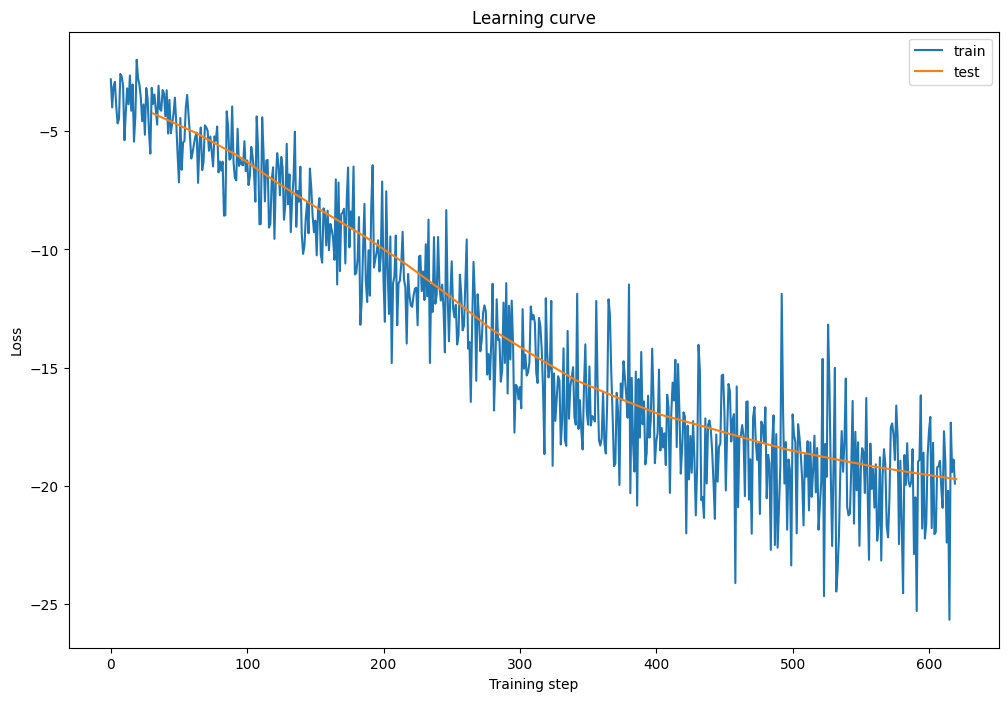

In [159]:
utils.show_learning_curve(train_metrics, test_metrics)

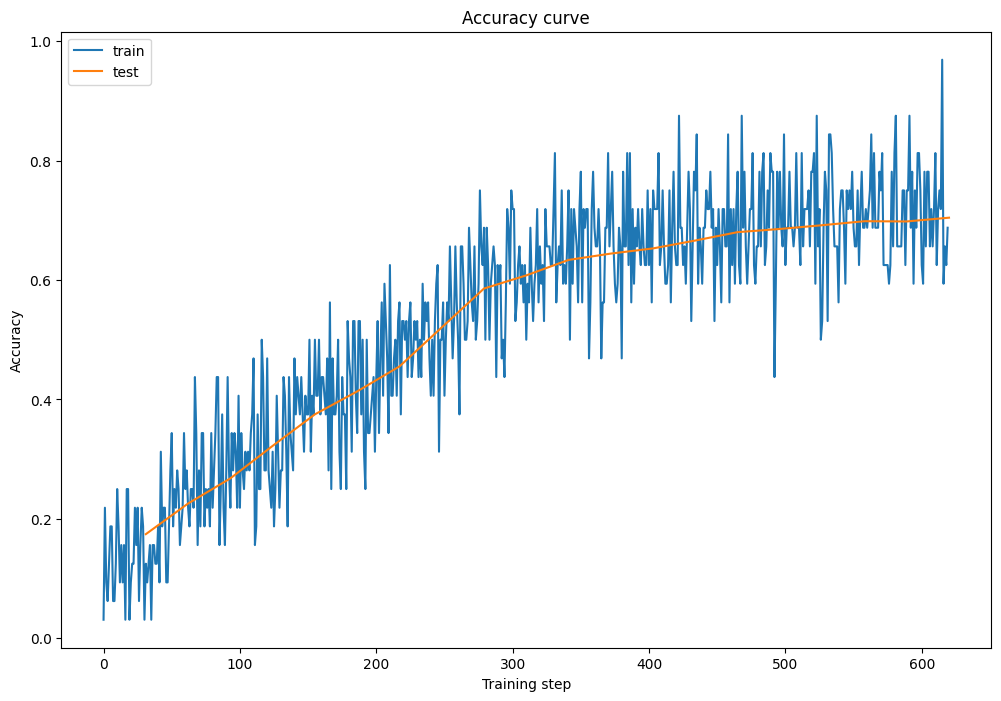

In [160]:
utils.show_accuracy_curve(train_metrics, test_metrics)

In [161]:
print(f"Best training accuracy: {max(train_metrics['acc'])}")
print(f"Best testing accuracy: {max(test_metrics['acc'])}")

Best training accuracy: 0.96875
Best testing accuracy: 0.7042999863624573


In [162]:
num_samplings = 10
analyzer = utils.Analyzer(model, test_dataset, num_samplings)

Top high confidence correct predictions


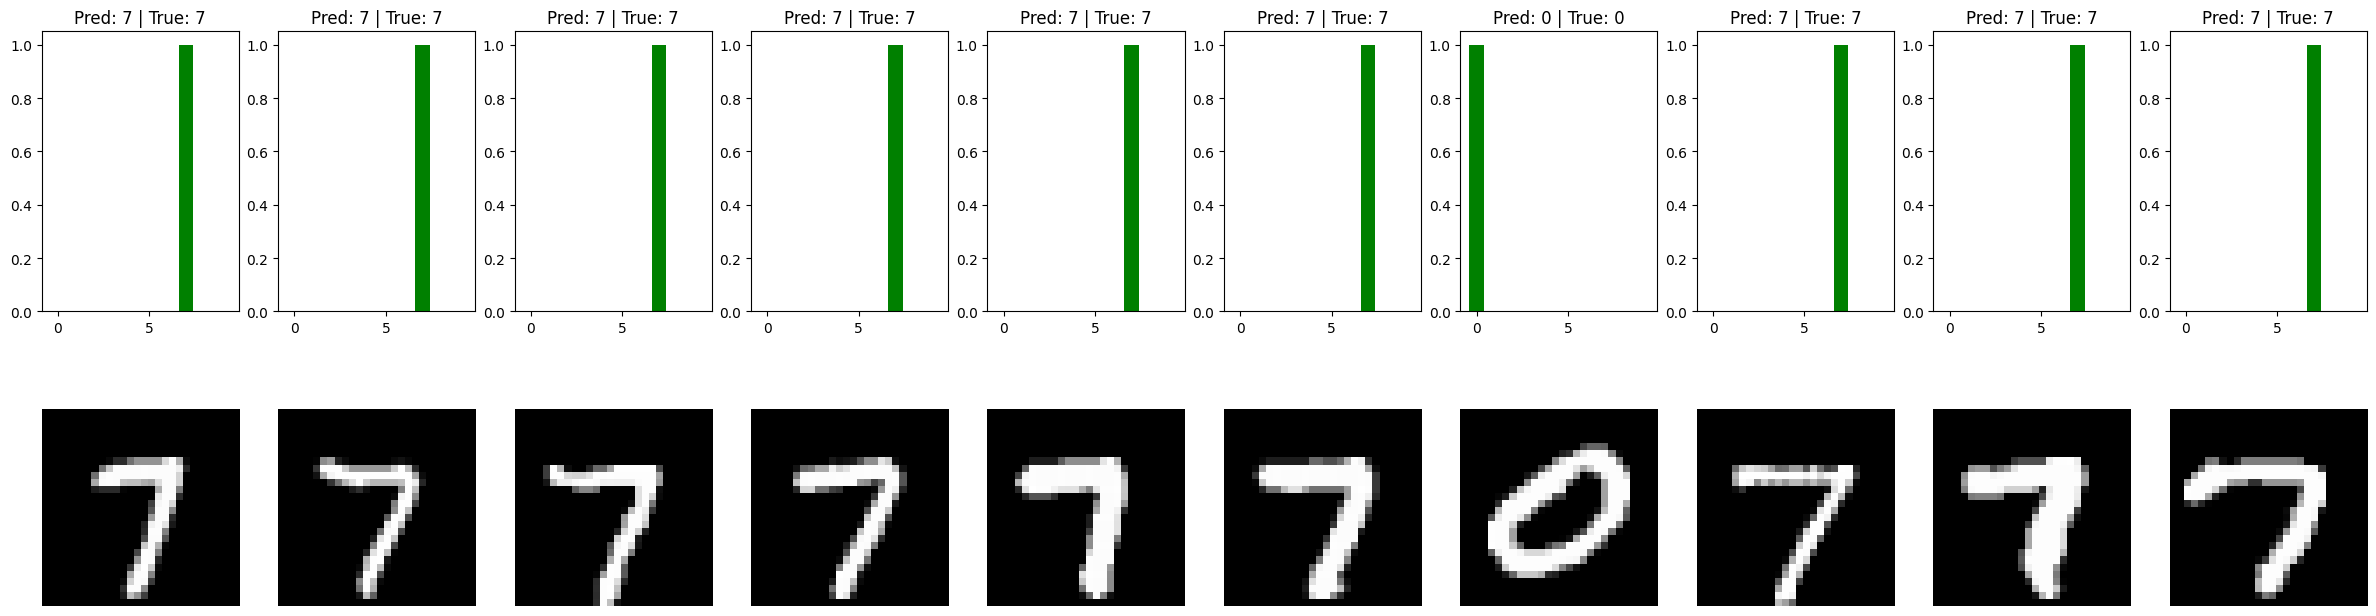

In [163]:
utils.visualize_samples(
    *analyzer.get_top_k_high_confidence_correct(10)
)
print("Top high confidence correct predictions")

Top low confidence correct predictions


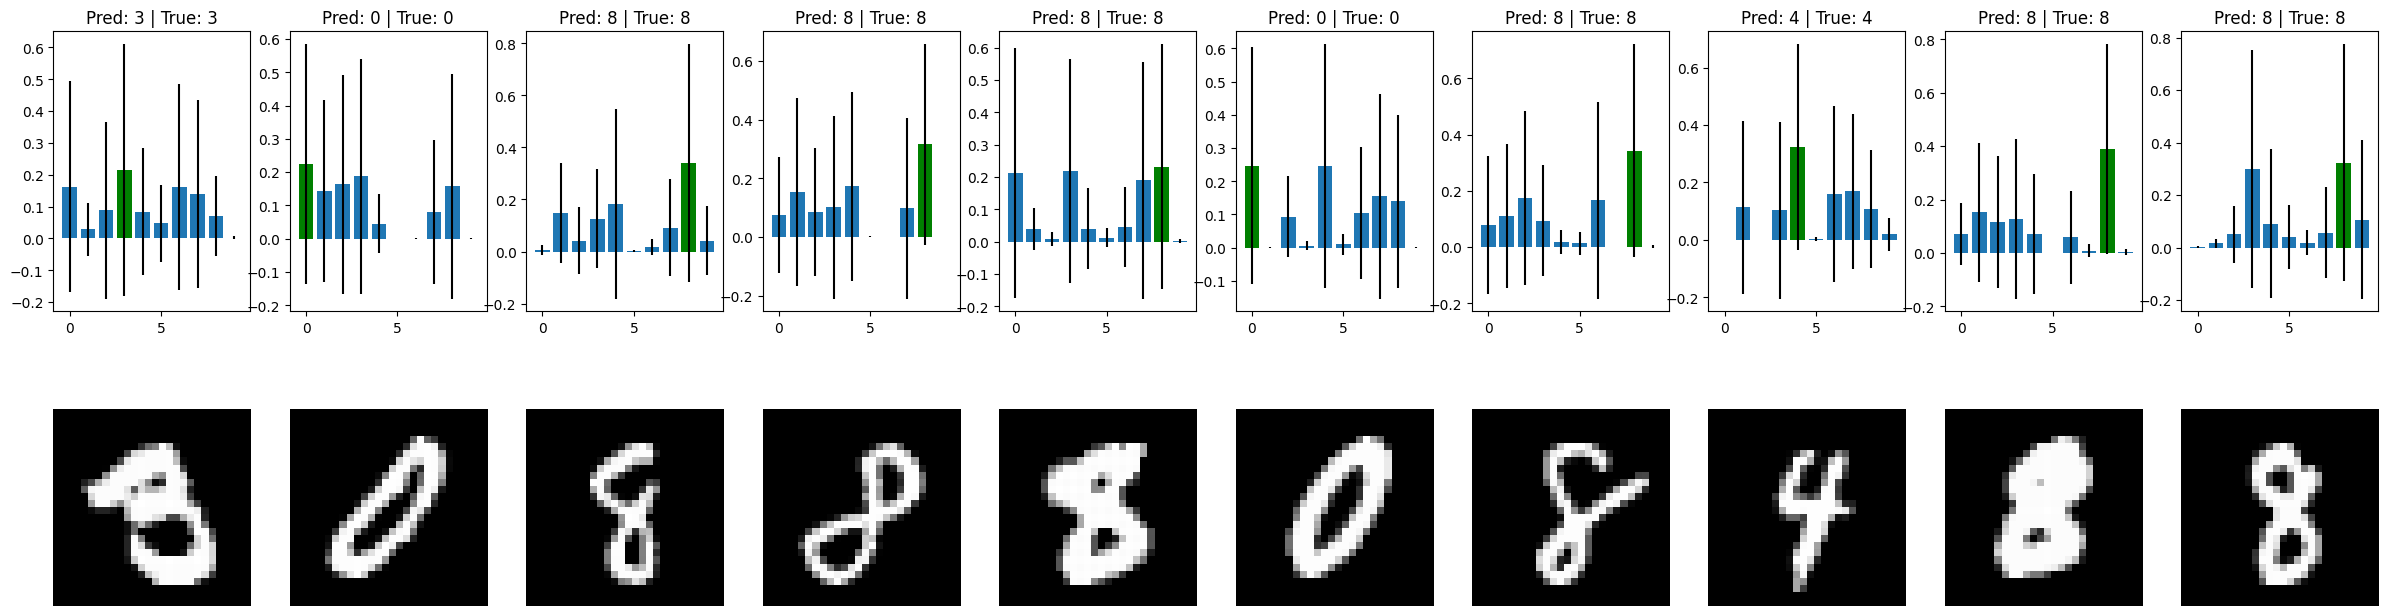

In [164]:
utils.visualize_samples(
    *analyzer.get_top_k_low_confidence_correct(10)
)
print("Top low confidence correct predictions")

Top low confidence wrong predictions


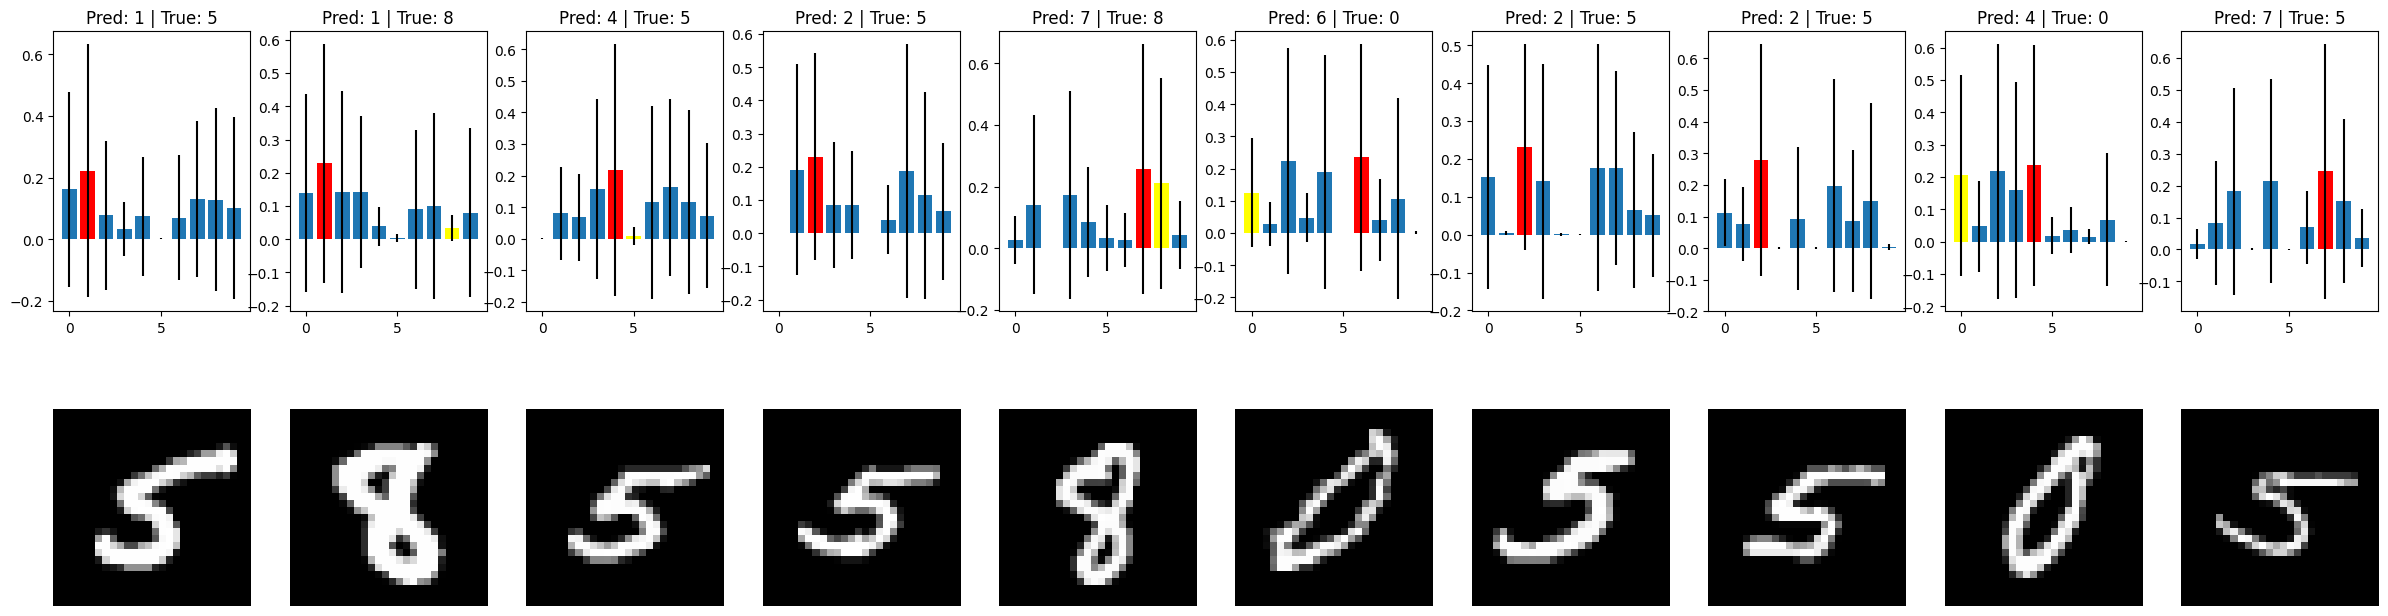

In [165]:
utils.visualize_samples(
    *analyzer.get_top_k_low_confidence_mistakes(10)
)

print("Top low confidence wrong predictions")

Top high confidence wrong predictions


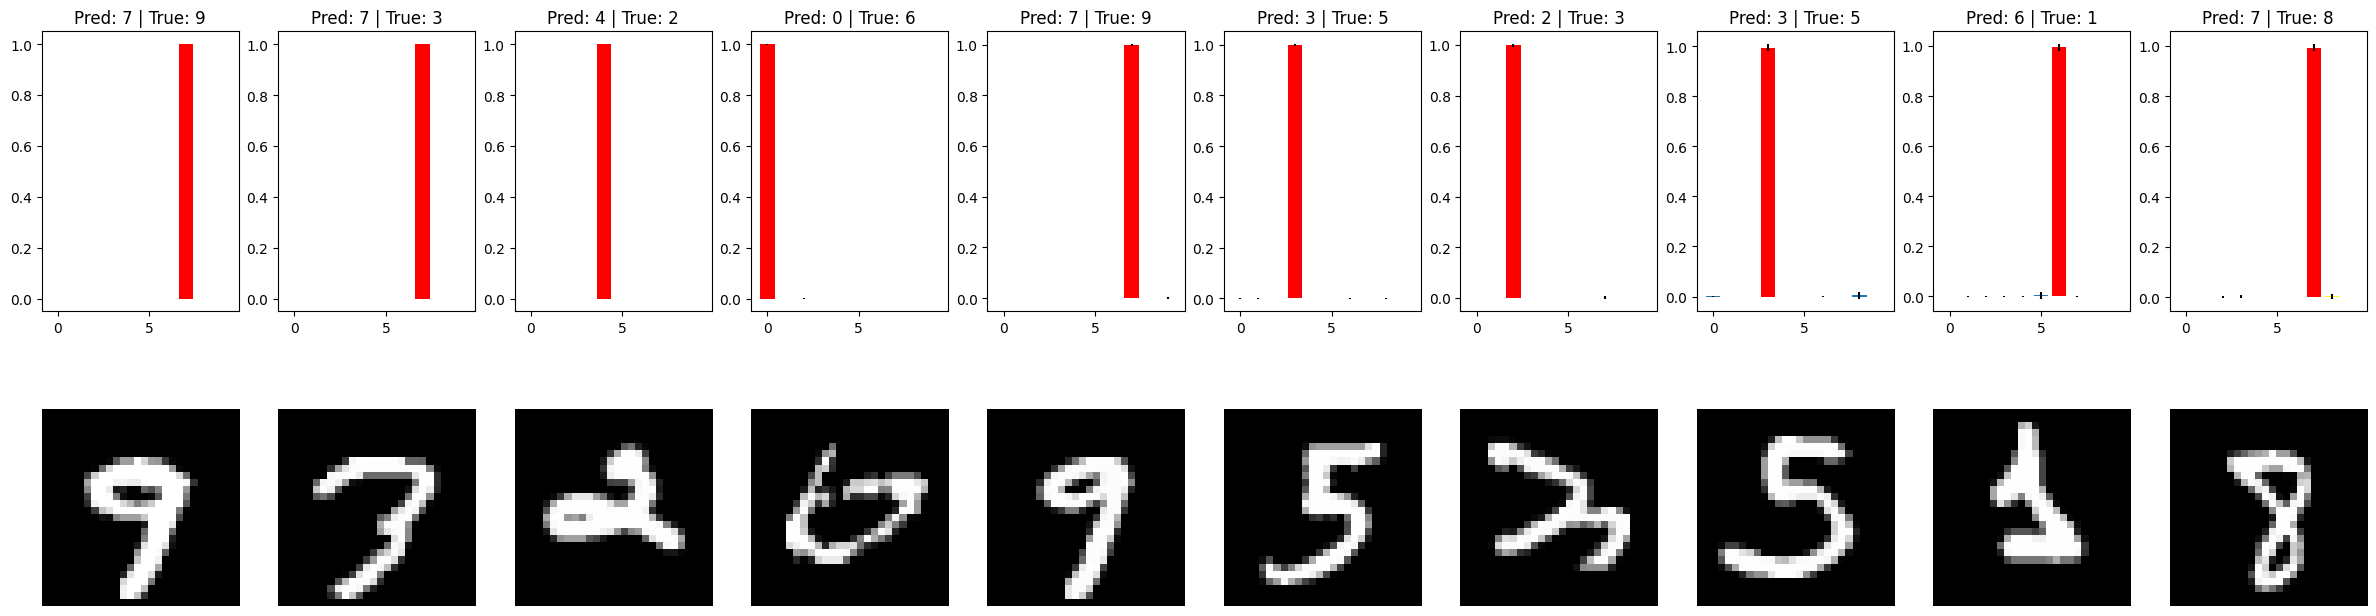

In [166]:
utils.visualize_samples(
    *analyzer.get_top_k_high_confidence_mistakes(10)
)

print("Top high confidence wrong predictions")

# Zadanie 3 (0.1 pkt)
Przypisz do zmiennych `layer_1_means` oraz `layer_2_means` wartości parametrów średnich rozkładu normalnego $\mu$ dla odpowiednio pierwszej i drugiej warstwy.

Histogram of weights for layer 1


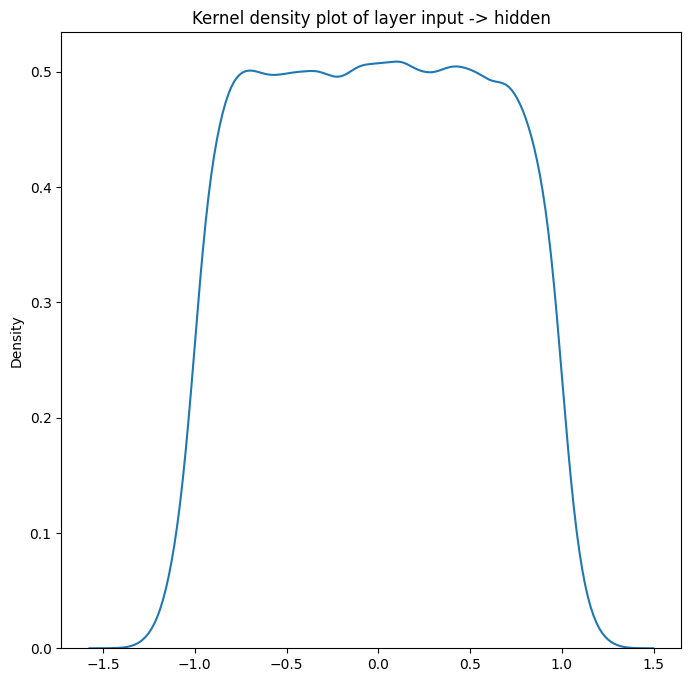

In [167]:
layer_1_means = model.layer_1.weight_mean

utils.visualize_weights(layer_1_means, "layer input -> hidden")
print("Histogram of weights for layer 1")

Histogram of weights for layer 2


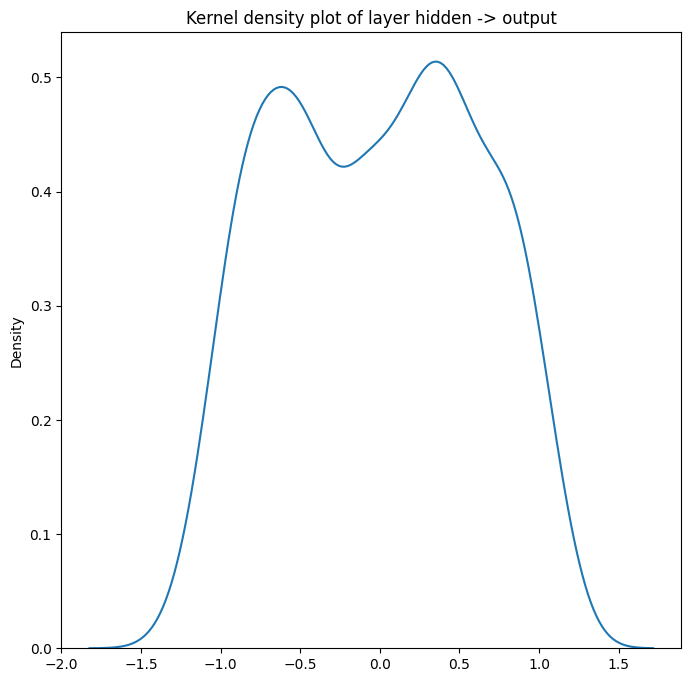

In [168]:
layer_2_means = model.layer_2.weight_mean

utils.visualize_weights(layer_2_means, "layer hidden -> output")
print("Histogram of weights for layer 2")

# Zadanie 4 (1.4 pkt)
Zbadaj wpływ hiperparametrów na działanie modelu:
- parametry w rozkładzie prior (tzn. `sigma_1`, `sigma_2`, `mixing`)
- co się stanie jeśli zastosujemy tylko jeden rozkład normalny jako prior (zamiast mikstury)?
- rozmiar mini-paczki (`batch_size`)
- współczynnik uczenia (`learning_rate`)

In [11]:
import pandas as pd

sigmas1 = [0.1, 0.5, 0.9]
sigmas2 = [1e-6, 1e-3, 0.1]
mixings = [0.3, 1]

summary = []

for sigma1 in sigmas1:
    for sigma2 in sigmas2:
        for mixing in mixings: 
            results_test = []
            results_train=[]
            
            model = BayesianMLP(
            num_input_features=28 * 28,  # pixels
            num_hidden_features=128,  # arbitrary number
            num_output_classes=10,  # num of digits
            )

            model.layer_1.prior = TwoGaussianMixturePrior(sigma1, sigma2, mixing)
            model.layer_2.prior = TwoGaussianMixturePrior(sigma1, sigma2, mixing)

            loss_fun = ELBO(N=5)
            optimizer = torch.optim.Adam(
                model.parameters(),
                lr=1e-3,
            )

            train_metrics, test_metrics = utils.fit_elbo(
                model=model,
                train_dataset=train_dataset,
                valid_dataset=test_dataset,
                loss_function=loss_fun,
                batch_size=32,
                epochs=5,
                optimizer=optimizer,
            )
            
            summary.append([sigma1,sigma2, mixing, max(train_metrics['acc']), max(test_metrics['acc'])])
                            
            print(f"-- Sigma_1 {sigma1}, sigma_2 {sigma2}, mixing {mixing}--")
            print(f"Train acc {max(train_metrics['acc'])}, test acc {max(test_metrics['acc'])}")
    
summary_df = pd.DataFrame(summary, columns=['Sigma_1','Sigma_2', 'mixing', 'train ACC', 'test ACC'])
print(summary_df)

Epoch: 1 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 2 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 3 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 4 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 5 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

-- Sigma_1 0.1, sigma_2 1e-06, mixing 0.3--
Train acc 0.5, test acc 0.29829999804496765
Epoch: 1 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 2 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 3 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 4 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 5 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

-- Sigma_1 0.1, sigma_2 1e-06, mixing 1--
Train acc 0.5, test acc 0.30230000615119934
Epoch: 1 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 2 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 3 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 4 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 5 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

-- Sigma_1 0.1, sigma_2 0.001, mixing 0.3--
Train acc 0.46875, test acc 0.34470000863075256
Epoch: 1 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 2 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 3 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 4 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 5 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

-- Sigma_1 0.1, sigma_2 0.001, mixing 1--
Train acc 0.46875, test acc 0.2874000072479248
Epoch: 1 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 2 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 3 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 4 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 5 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

-- Sigma_1 0.1, sigma_2 0.1, mixing 0.3--
Train acc 0.53125, test acc 0.3734999895095825
Epoch: 1 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 2 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 3 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 4 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 5 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

-- Sigma_1 0.1, sigma_2 0.1, mixing 1--
Train acc 0.34375, test acc 0.23119999468326569
Epoch: 1 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 2 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 3 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 4 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 5 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

-- Sigma_1 0.5, sigma_2 1e-06, mixing 0.3--
Train acc 0.53125, test acc 0.3156999945640564
Epoch: 1 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 2 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 3 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 4 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 5 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

-- Sigma_1 0.5, sigma_2 1e-06, mixing 1--
Train acc 0.53125, test acc 0.34279999136924744
Epoch: 1 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 2 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 3 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 4 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 5 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

-- Sigma_1 0.5, sigma_2 0.001, mixing 0.3--
Train acc 0.5625, test acc 0.2948000133037567
Epoch: 1 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 2 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 3 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 4 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 5 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

-- Sigma_1 0.5, sigma_2 0.001, mixing 1--
Train acc 0.5, test acc 0.3248000144958496
Epoch: 1 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 2 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 3 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 4 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 5 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

-- Sigma_1 0.5, sigma_2 0.1, mixing 0.3--
Train acc 0.5625, test acc 0.30730000138282776
Epoch: 1 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 2 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 3 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 4 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 5 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

-- Sigma_1 0.5, sigma_2 0.1, mixing 1--
Train acc 0.59375, test acc 0.275299996137619
Epoch: 1 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 2 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 3 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 4 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 5 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

-- Sigma_1 0.9, sigma_2 1e-06, mixing 0.3--
Train acc 0.625, test acc 0.3614000082015991
Epoch: 1 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 2 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 3 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 4 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 5 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

-- Sigma_1 0.9, sigma_2 1e-06, mixing 1--
Train acc 0.5625, test acc 0.33219999074935913
Epoch: 1 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 2 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 3 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 4 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 5 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

-- Sigma_1 0.9, sigma_2 0.001, mixing 0.3--
Train acc 0.4375, test acc 0.2768999934196472
Epoch: 1 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 2 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 3 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 4 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 5 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

-- Sigma_1 0.9, sigma_2 0.001, mixing 1--
Train acc 0.46875, test acc 0.275299996137619
Epoch: 1 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 2 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 3 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 4 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 5 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

-- Sigma_1 0.9, sigma_2 0.1, mixing 0.3--
Train acc 0.53125, test acc 0.29330000281333923
Epoch: 1 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 2 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 3 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 4 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 5 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

-- Sigma_1 0.9, sigma_2 0.1, mixing 1--
Train acc 0.5, test acc 0.3230000138282776
    Sigma_1   Sigma_2  mixing  train ACC  test ACC
0       0.1  0.000001     0.3    0.50000    0.2983
1       0.1  0.000001     1.0    0.50000    0.3023
2       0.1  0.001000     0.3    0.46875    0.3447
3       0.1  0.001000     1.0    0.46875    0.2874
4       0.1  0.100000     0.3    0.53125    0.3735
5       0.1  0.100000     1.0    0.34375    0.2312
6       0.5  0.000001     0.3    0.53125    0.3157
7       0.5  0.000001     1.0    0.53125    0.3428
8       0.5  0.001000     0.3    0.56250    0.2948
9       0.5  0.001000     1.0    0.50000    0.3248
10      0.5  0.100000     0.3    0.56250    0.3073
11      0.5  0.100000     1.0    0.59375    0.2753
12      0.9  0.000001     0.3    0.62500    0.3614
13      0.9  0.000001     1.0    0.56250    0.3322
14      0.9  0.001000     0.3    0.43750    0.2769
15      0.9  0.001000     1.0    0.46875    0.2753
16      0.9  0.100000     0.3    0.53125    0.2933

In [12]:
class SingleGaussianPrior:
    
    def __init__(
        self, 
        sigma: float = 1, 
    ):
        
        self.w_prior = torch.distributions.Normal(0, sigma)
        self.b_prior = torch.distributions.Normal(0, sigma)
        
    def log_prob(self, weights: torch.Tensor, biases: torch.Tensor):
        w_log_prior = self.w_prior.log_prob(weights).exp()

        b_log_prior = self.b_prior.log_prob(biases).exp()
    
        # We don't want this log probability to depend on 
        # the actual number of network parameters (weights+biases),
        # so we compute the mean instead of a sum.
        return w_log_prior.log().mean() + b_log_prior.log().mean()
    
tested_model = BayesianMLP(
    num_input_features=28 * 28,  # pixels
    num_hidden_features=128,  # arbitrary number
    num_output_classes=10,  # num of digits
)
tested_model.layer_1.prior = SingleGaussianPrior(1e-6)
tested_model.layer_2.prior = SingleGaussianPrior(1e-6)

loss_fun = ELBO(N=5)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-3,
)

train_metrics, test_metrics = utils.fit_elbo(
    model=tested_model,
    train_dataset=train_dataset,
    valid_dataset=test_dataset,
    loss_function=loss_fun,
    batch_size=32,
    epochs=10,
    optimizer=optimizer,
)

print(f"Single-gaussian prior:")
print(f"Train accuracy: {max(train_metrics['acc'])}")
print(f"Test accuracy: {max(test_metrics['acc'])}")

Epoch: 1 / 10


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 2 / 10


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 3 / 10


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 4 / 10


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 5 / 10


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 6 / 10


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 7 / 10


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 8 / 10


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 9 / 10


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 10 / 10


  0%|          | 0/31 [00:00<?, ?it/s]

Single-gaussian prior:
Train accuracy: 0.28125
Test accuracy: 0.08789999783039093


In [14]:
batch_sizes = [8, 16, 32, 64]
summary = []

for batch_size in batch_sizes:
    model = BayesianMLP(
        num_input_features=28 * 28,  # pixels
        num_hidden_features=128,  # arbitrary number
        num_output_classes=10,  # num of digits
    )

    loss_fun = ELBO(N=5)
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=1e-3,
    )

    train_metrics, test_metrics = utils.fit_elbo(
        model=model,
        train_dataset=train_dataset,
        valid_dataset=test_dataset,
        loss_function=loss_fun,
        batch_size=batch_size,
        epochs=5,
        optimizer=optimizer,
    )
    summary.append([batch_size, max(train_metrics['acc']), max(test_metrics['acc'])])
                            
    print(f"-- Batch size {batch_size}--")
    print(f"Train acc {max(train_metrics['acc'])}, test acc {max(test_metrics['acc'])}")
    
summary_df = pd.DataFrame(summary, columns=['batch_size', 'train ACC', 'test ACC'])
print(summary_df)


Epoch: 1 / 5


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 2 / 5


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 3 / 5


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 4 / 5


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 5 / 5


  0%|          | 0/125 [00:00<?, ?it/s]

-- Batch size 8--
Train acc 0.875, test acc 0.4025000035762787
Epoch: 1 / 5


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 2 / 5


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 3 / 5


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 4 / 5


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 5 / 5


  0%|          | 0/62 [00:00<?, ?it/s]

-- Batch size 16--
Train acc 0.75, test acc 0.38830000162124634
Epoch: 1 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 2 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 3 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 4 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 5 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

-- Batch size 32--
Train acc 0.625, test acc 0.29989999532699585
Epoch: 1 / 5


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 2 / 5


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 3 / 5


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 4 / 5


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 5 / 5


  0%|          | 0/15 [00:00<?, ?it/s]

-- Batch size 64--
Train acc 0.328125, test acc 0.23839999735355377
   batch_size  train ACC  test ACC
0           8   0.875000    0.4025
1          16   0.750000    0.3883
2          32   0.625000    0.2999
3          64   0.328125    0.2384


In [21]:
learning_rates = [0.0005, 0.001, 0.002]

summary = []

for learning_rate in learning_rates:
    model = BayesianMLP(
        num_input_features=28 * 28,  # pixels
        num_hidden_features=128,  # arbitrary number
        num_output_classes=10,  # num of digits
    )

    loss_fun = ELBO(N=5)
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=learning_rate,
    )

    train_metrics, test_metrics = utils.fit_elbo(
        model=model,
        train_dataset=train_dataset,
        valid_dataset=test_dataset,
        loss_function=loss_fun,
        batch_size=32,
        epochs=5,
        optimizer=optimizer,
    )
    summary.append([learning_rate, max(train_metrics['acc']), max(test_metrics['acc'])])
                            
    print(f"-- Learning rate {learning_rate}--")
    print(f"Train acc {max(train_metrics['acc'])}, test acc {max(test_metrics['acc'])}")
    
summary_df = pd.DataFrame(summary, columns=['learning_rate', 'train ACC', 'test ACC'])
print(summary_df)


Epoch: 1 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 2 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 3 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 4 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 5 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

-- Learning rate 0.0005--
Train acc 0.375, test acc 0.21140000224113464
Epoch: 1 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 2 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 3 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 4 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 5 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

-- Learning rate 0.001--
Train acc 0.4375, test acc 0.3093999922275543
Epoch: 1 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 2 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 3 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 4 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 5 / 5


  0%|          | 0/31 [00:00<?, ?it/s]

-- Learning rate 0.002--
Train acc 0.6875, test acc 0.4327999949455261
   learning_rate  train ACC  test ACC
0         0.0005     0.3750    0.2114
1         0.0010     0.4375    0.3094
2         0.0020     0.6875    0.4328
